## Creating colour palettes from Planet Labs images

This tutorial is based on the [Urban Goggles project](https://github.com/adrn/urbangoggles) created at [AstroHackWeek 2016](http://astrohackweek.org/2016/). More information can be found ond on the [AHW Wiki](https://github.com/AstroHackWeek/AstroHackWeek2016/wiki)<br>
Location: GitHub HQ (San Francisco) & Berkeley Institute for Data Science, 29th August – 2nd September, 2016. <br>


This Notebook takes you through each step of the process, dissecting some of the functions along the way. The code has been adapted to suit the Apollo images and for the purposes of this tutorial. The images are taken from the [Planet Labs Gallery](https://www.planet.com/). 

Target audience: those who are new(-ish) to Python and would like to start using the matplotlib and scikit-learn packages.

#### Target audience: 

Those who are new to Python and would like to start using the matplotlib and scikit-learn packages. Experience or familiarity with other programming languages (dare I say Fortran, IDL etc.) may be helpful. Comments and suggestions welcome.

#### Acknowledgements: 

Thanks to [Adrian–Price Whelan](https://twitter.com/adrianprw) (Princeton), [Dan Foreman–Mackey](https://twitter.com/exoplaneteer) (University of Washington), and Ben Nelson (CIERA - Northwestern University), for sharing their code.

### New to matplotlib and Jupyter notebooks?

* **numpy** reference manual: https://docs.scipy.org/doc/numpy/reference/index.html <br>
* Adding ** plt.style.use('my_pltstyle')** afther implot matplotlib.pyplot allows you to customise plotting by using style sheets. Details can be found here: http://matplotlib.org/users/style_sheets.html<br>
* **pyplot** provides a MATLAB-like plotting framework. For details see here: 
http://matplotlib.org/api/pyplot_api.html <br>
* **skimage** refers to the scikit-learn image algorithms for Python. For an overview see here: http://scikit-image.org/ and for details about the various functions see here: http://scikit-image.org/docs/dev/api/api.html

Also useful, is the **markdown** guide: http://markdown-guide.readthedocs.io/en/latest/

#### Additional resources & similar examples: ####
A crash course on NumPy for images: http://scikit-image.org/docs/dev/user_guide/numpy_images.html
Finding Dominant Image Colours Using Python:  http://blog.zeevgilovitz.com/detecting-dominant-colours-in-python/

In [367]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.data as sd
import skimage.color as color
import skimage.transform as st
from skimage.io import imread

from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

In [368]:
image_filename = "planetlabs_images/great-barrier-reef"
# image_filename = "planetlabs_images/north-caucasus-agriculture"  # Make sure you try running the Notebook with this image
# image_filename = "planetlabs_images/lethbridge-rapideye-nir"
# image_filename = "planetlabs_images/venice"

In this example, the [image we're using](https://www.planet.com/gallery/reef-20160708/) is part of the Great Barrier Reef which stretches for 1,400 miles along the coast of Queensland, Australia in the Coral Sea. You can see tidal channels cutting through unnamed reefs.

** A quick intro image arrays: **

First we need to create a data array from the image: https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imread.html#scipy.misc.imread. The images use in this example are 1200x900px. The image pixel arrays are defined by their [row, column] from the top left corner of the image. 
The final data array will be a set of RGB values corresponding to each pixel for each channel, ie. [rows, column, RBG channel]




In [369]:
rgb = np.array(imread(image_filename+".jpg")[...,:3], dtype=np.float64)
rgb.min(), rgb.max()
#print('min value')
print(rgb.min())
#print('max value')
print(rgb.max())
#print('image size')
print(rgb.shape)
print(rgb.size)
pixels_per_image = rgb.size
rgb = st.rescale(rgb, 1.0)

0.0
255.0
(900, 1200, 3)
3240000


Just for fun we'll print the RBG values for the pixel in the first row and column. We can do this for individual channels by specifying 0, 1, or 2, or we can get the value for all three by doing this;

In [370]:
# Print the R, G, B values
print(rgb[0,0,:3])

[ 155.  187.  176.]


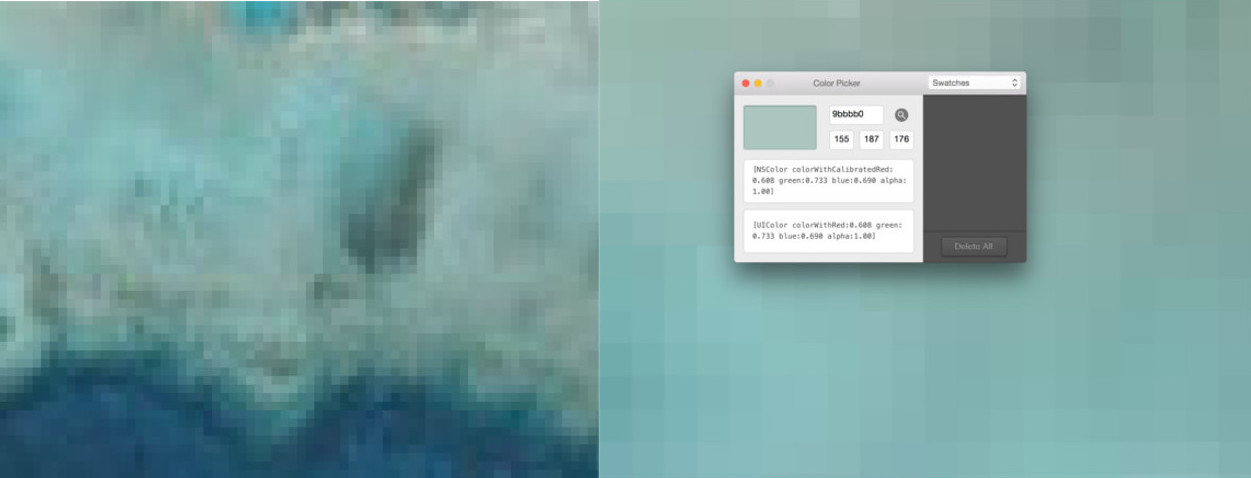

In [371]:
# You can see this by displaying (zooming in) the image and using a tool like color picker 
# (https://itunes.apple.com/au/app/color-picker/id641027709?mt=12) to verify the value of each pixel
# See the screenshot below
Image('planetlabs_images/reef_pixels.jpg')

** Image manipulation:**

First we convert to floats instead of the default 8 bits integer coding. Dividing by 255 is important so that **plt.imshow** behaves and works well on float data. Essentially we're normalising RGB values so that they go from [0, 1.0]. We also want to rescale the image size (e.g. 0.1 = 10%) to reduce the flood of pixels.

In [372]:
rgb = np.array(imread(image_filename+".jpg")[...,:3], dtype=np.float64) / 255
rgb = st.rescale(rgb, 0.2)
print(rgb.shape)
print(rgb.size)
print(rgb[0,0,:3])

(180, 240, 3)
129600
[ 0.59215686  0.71372549  0.68235294]


In [373]:
# Transform to a 2D numpy array.
# For a description of tuples, see here: http://openbookproject.net/thinkcs/python/english3e/tuples.html

w, h, d = original_shape = tuple(rgb.shape)
assert d == 3
rgb_data = np.reshape(rgb, (w * h, d))
print(rgb_data.shape)
print(rgb_data)

(43200, 3)
[[ 0.59215686  0.71372549  0.68235294]
 [ 0.59215686  0.69411765  0.65882353]
 [ 0.58431373  0.6745098   0.64313725]
 ..., 
 [ 0.12156863  0.1372549   0.23529412]
 [ 0.13333333  0.14117647  0.23137255]
 [ 0.11764706  0.14901961  0.22352941]]


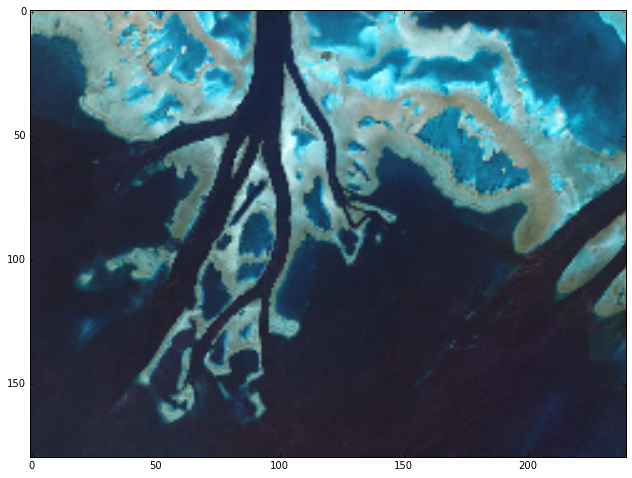

In [374]:
plt.figure(figsize=(12,8))
#figsize = (width, height) in inches
plt.imshow(rgb)

### Custering in HSV space: 

Some useful references:

* Hue, saturation, lightness (HSL) and hue, saturation, and value (HSV): https://en.wikipedia.org/wiki/HSL_and_HSV<br>
* Sci-kit image rgb2hsv color module: http://scikit-image.org/docs/dev/api/skimage.color.html?highlight=color%20rgb2hsv#skimage.color.rgb2hsv<br>
* Numpy reshape: https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
* Pyplot tutorial: http://matplotlib.org/users/pyplot_tutorial.html

**A few notes about K-means clustering and similar algorithms:**

Wikipedia has a nice introduction to [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). In astronomy, bimodal mixture-modelling (KMM) algorithms are widely used to separate populations. I've used KMM to determine whether clusters of galaxies exhibit sub-structure in terms of their galaxy position and radial velocity distributions. Expectation-Maximisation is used to determine the parameters.   K-means clustering is a little different.

K-means defines 'hard clusters', i.e. the sub-populations are assumed to fit into N definded clusters, whereas mixture-models allow you to determine the number of sub-populations without necessarily assigning each data point to a sub-cluster. In KMM the  sub-populations are essentially probablilty distributions. With a K-means algorithm, you pre-define the number of clusters (k), then seed k random points throughout the parameter space. Each data point is then assigned to the cluster with the nearest centroid, the new centroid is computed, and the data points added and centroids computed iteratively until the algorithm converges on a solution. K-means is a special case of Mixture of Gaussian, which is a special case of Expectation-Maximisation... I think. I need to go back and look at each of these in more detail.


A really nice description of K-means clustering using numpy can be found on the Data Science Lab blog, *[Clustering With K-Means in Python](
https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/)*. It's one of several blog posts on the topic.

What this is means is that you have the freedom to decide how many clusters you want: 
**clf = KMeans(n_clusters=6)**. For these images I settled for 6-8, because that was close to what I would expect, based on a quick visual inspection of each image. I recommend playing around with this parameter so you can get a bettter feeling for what's going on.




In [375]:
hsv_data = color.rgb2hsv(rgb)
hsv = hsv_data.reshape(-1, 3).T

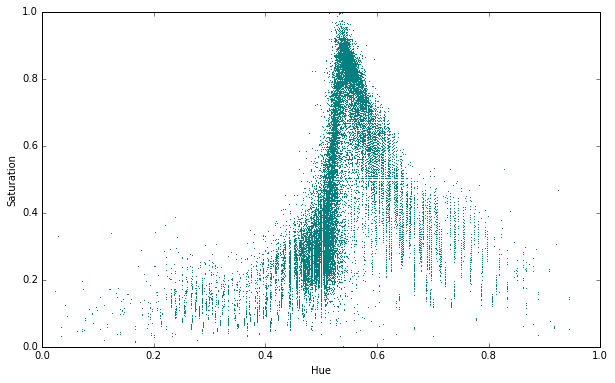

In [376]:
plt.figure(figsize=(10,6))
plt.plot(hsv[0], hsv[1], linestyle='none', c='teal', alpha=1., marker=',');

plt.xlabel('Hue')
plt.ylabel('Saturation')

In [377]:
phi = 2*np.pi*hsv[0]
x = hsv[1]*np.cos(phi)
y = hsv[1]*np.sin(phi)
z = hsv[2]

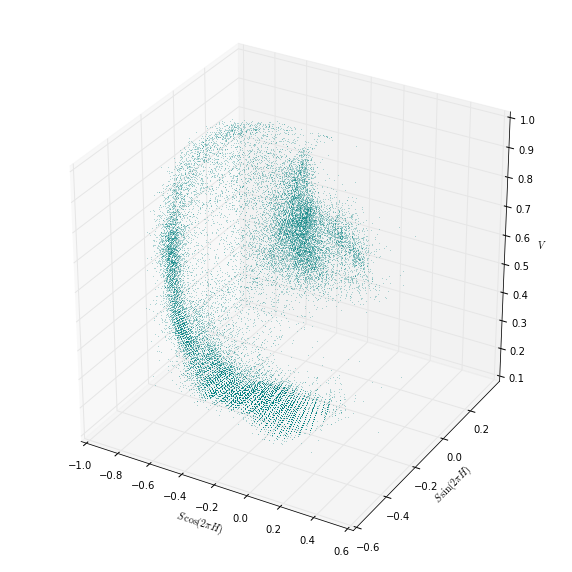

In [378]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,projection='3d')
plt.plot(x, y, z, linestyle='none', c='teal', alpha=0.3, marker=',');

ax.set_xlabel(r'$S\,\cos (2\pi H)$')
ax.set_ylabel(r'$S\,\sin (2\pi H)$')
ax.set_zlabel(r'$V$')

In [379]:
X = np.vstack((x,y,z)).T
subset = shuffle(X)

In [380]:
clf = KMeans(n_clusters=6)
clf.fit(subset)
centroids = clf.cluster_centers_

# clf = GMM(n_components=16, )
# clf.fit(subset)
# centroids = clf.means_
# centroids = centroids[np.argsort(clf.weights_)]

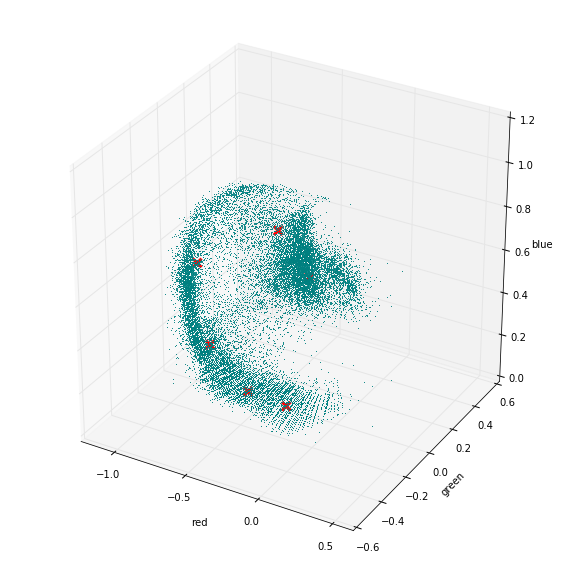

In [381]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,projection='3d')

ax.plot(subset[:,0], subset[:,1], subset[:,2], c='teal', linestyle='none', alpha=0.9, marker=',', zorder=10)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='red', marker='x', alpha=1., s=75, linewidths=3,  zorder=0)

ax.set_xlabel(r'red')
ax.set_ylabel(r'green')
ax.set_zlabel(r'blue')

### Generating the color maps – Clustering in HSV space

In [382]:
rgb_clusters = color.hsv2rgb(centroids[None])[0]

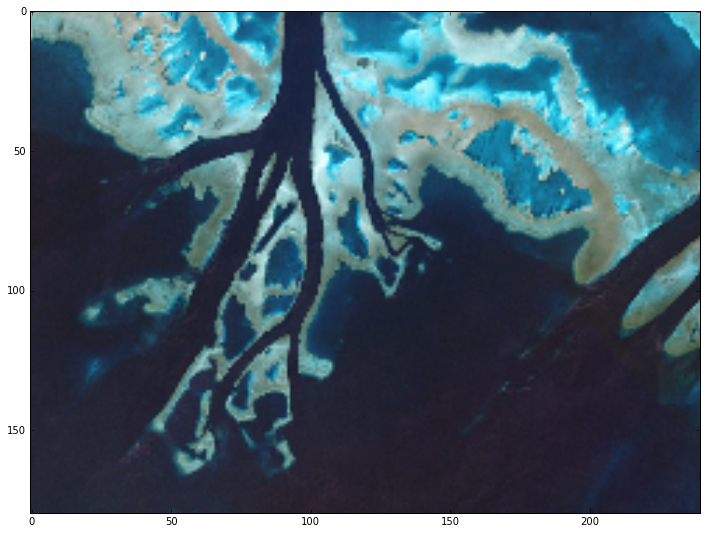

In [383]:
plt.figure(figsize=(12,10))
plt.imshow(rgb)

Now we generate the color map from the HSV clusters or centroids.
Dissection:  the len() function is a built-in python function that just returns the length or number of things in an object. In this case eight clusters. np.sqrt() returns the positive square root of each element. int() just returns the integer. The syntax for these functions are fairly standard across programming languages.


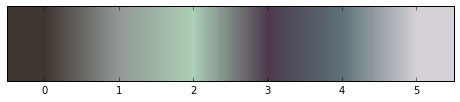

In [384]:
_n = int(np.sqrt(len(centroids)))
fig,ax = plt.subplots(1,1,figsize=(8,2))
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#http://matplotlib.org/users/image_tutorial.html
ax.imshow(rgb_clusters.reshape(1,len(centroids),3))
#print(len(centroids))
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(False)

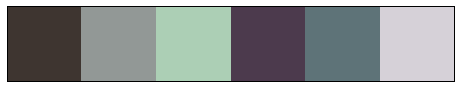

In [385]:
_n = int(np.sqrt(len(centroids)))
fig,ax = plt.subplots(1,1,figsize=(8,2))

ax.imshow(rgb_clusters.reshape(1,len(centroids),3), interpolation='nearest')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.savefig(image_filename+"_hsv_palette.jpg", dpi=100)

In [386]:
bins = np.linspace(0,1,16)
H,edges = np.histogramdd(X, bins=(bins,bins,bins))

In [387]:
from scipy.ndimage import gaussian_filter

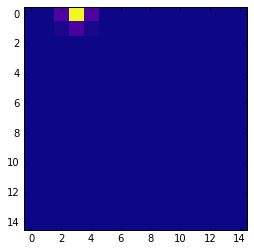

In [388]:
# plt.imshow(np.sum(H, axis=1))
plt.imshow(gaussian_filter(H, 0.5)[6], interpolation='nearest', cmap='plasma')

### Clustering in RGB space:

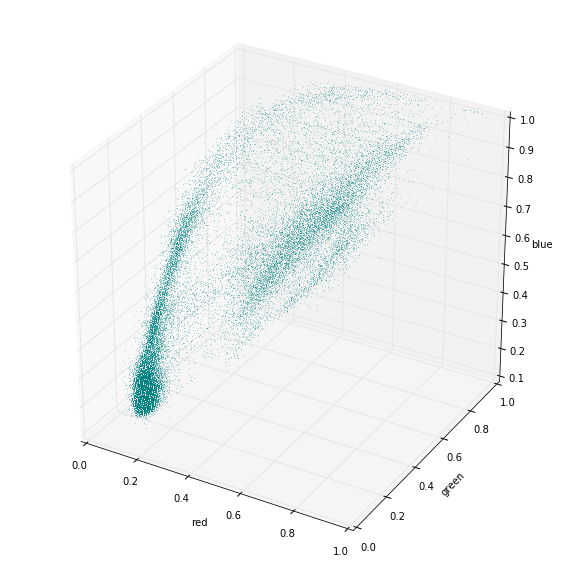

In [389]:
x = rgb_data[...,0].ravel()
y = rgb_data[...,1].ravel()
z = rgb_data[...,2].ravel()

plt.figure(figsize=(10,10))

ax = plt.subplot(1,1,1,projection='3d')
plt.plot(x, y, z, linestyle='none', c='teal', alpha=0.3, marker=',');

ax.set_xlabel(r'red')
ax.set_ylabel(r'green')
ax.set_zlabel(r'blue')

In [390]:
X = np.vstack((x,y,z)).T
subset = shuffle(X)

In [391]:
clf = KMeans(n_clusters=6)
clf.fit(subset)
centroids = clf.cluster_centers_

# clf = GMM(n_components=16, )
# clf.fit(subset)
# centroids = clf.means_
# centroids = centroids[np.argsort(clf.weights_)]

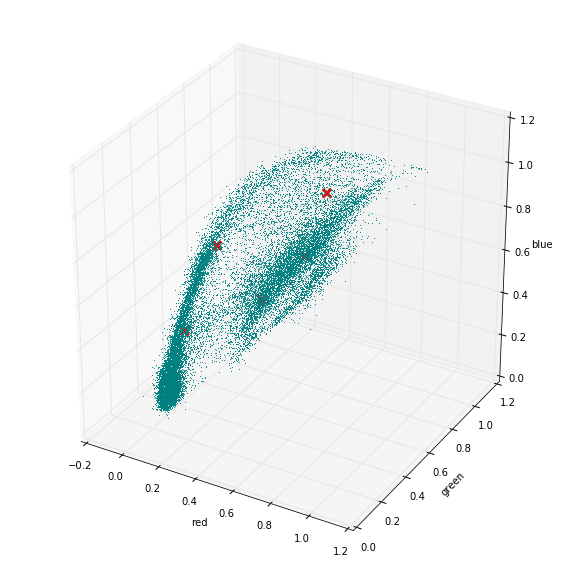

In [392]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,projection='3d')

ax.plot(subset[:,0], subset[:,1], subset[:,2], linestyle='none', c='teal', alpha=0.9, marker=',', zorder=10);
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x',
           c='red', alpha=1., s=75, linewidths=3,  zorder=0);

ax.set_xlabel(r'red')
ax.set_ylabel(r'green')
ax.set_zlabel(r'blue')

In [393]:
rgb_clusters = centroids

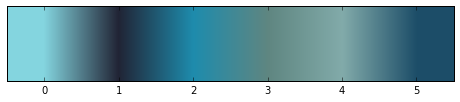

In [394]:
_n = int(np.sqrt(len(centroids)))
fig,ax = plt.subplots(1,1,figsize=(8,2))
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#http://matplotlib.org/users/image_tutorial.html
ax.imshow(rgb_clusters.reshape(1,len(centroids),3))
#print(len(centroids))
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(False)

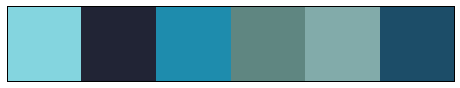

In [395]:
_n = int(np.sqrt(len(centroids)))
fig,ax = plt.subplots(1,1,figsize=(8,2))

ax.imshow(rgb_clusters.reshape(1,len(centroids),3), interpolation='nearest')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.savefig(image_filename+"_rgb_palette.jpg", dpi=100)

In [396]:
bins = np.linspace(0,1,16)
H,edges = np.histogramdd(X, bins=(bins,bins,bins))

In [397]:
from scipy.ndimage import gaussian_filter

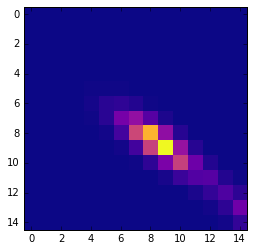

In [398]:
# plt.imshow(np.sum(H, axis=1))
plt.imshow(gaussian_filter(H, 0.5)[6], interpolation='nearest', cmap='plasma')

### Congratulations! You've created your first color palettes.

### Further resources and some more examples:
* A crash course on NumPy for images: http://scikit-image.org/docs/dev/user_guide/numpy_images.html
* Finding Dominant Image Colours Using Python:  http://blog.zeevgilovitz.com/detecting-dominant-colours-in-python/